In [1]:
import os

download_name = "frankenstein_with_splits.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a04/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()

name = "frankenstein_with_splits.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))        

# SOLUTION: Learning Embeddings with Continuous Bag of Words (CBOW)

## Imports

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


from nlp import StepByStep, Vectorizer, Vocabulary
from itertools import chain

def allclose(a, b, atol=1e-4):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)
    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)
    return torch.allclose(a, b, atol=atol)

## Dataframes

In [3]:
cbow_df = pd.read_csv("frankenstein_with_splits.csv")

train_df = cbow_df[cbow_df.split == "train"]
val_df = cbow_df[cbow_df.split == "val"]
test_df = cbow_df[cbow_df.split == "test"]

train_df

,context,target,split
0,", or the",frankenstein,train
1,frankenstein or the modern,",",train
2,"frankenstein , the modern prometheus",or,train
3,"frankenstein , or modern prometheus by",the,train
4,", or the prometheus by mary",modern,train
...,...,...,...
63484,"i had feelings affection , and",of,train
63485,"had feelings of , and they",affection,train
63486,feelings of affection and they were,",",train
63487,"of affection , they were requited",and,train


## Vocabulary

👍
Create variables:
* `cbow_vocab` as instance of `Vocabulary` having `<pad>` as pad token and `<unk>` as unknown token and `cuttoff` set to `5`.
* fill `cbow_vocab` with words from context and target words from `train_df`
* `cbow_size` as length of the longest word window of context from `train_df`

In [4]:
cbow_size = max(train_df.context.apply(str.split).apply(len))
cbow_vocab = Vocabulary(pad_tok="<pad>", unk_tok="<unk>")

tokens = [w 
          for window in train_df.context
          for w in window.split()]

tokens += [w
           for w in train_df.target
           if isinstance(w, str)]

cbow_vocab.fill(tokens, cutoff=5)

# test
assert cbow_size == 6
assert len(cbow_vocab) == 6125
assert cbow_vocab["<pad>"] == 0
assert cbow_vocab["<unk>"] == 1
assert cbow_vocab["monster"] == 3516
assert cbow_vocab.inv[6124] == "zeal"

## Splitted vocabularized datasets

In [5]:
x_train = cbow_vocab.pad_many(train_df.context.apply(str.split), cbow_size)
y_train = cbow_vocab.vocabularize(train_df.target.fillna(cbow_vocab.pad_tok))

x_val = cbow_vocab.pad_many(val_df.context.apply(str.split), cbow_size)
y_val = cbow_vocab.vocabularize(val_df.target.fillna(cbow_vocab.pad_tok))

x_test = cbow_vocab.pad_many(test_df.context.apply(str.split), cbow_size)
y_test = cbow_vocab.vocabularize(test_df.target.fillna(cbow_vocab.pad_tok))

## Dataset

In [6]:
class CBOWDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)


## The Model: CBOW

👍 Create `CBOWModel` class as MLP with single embedding layer and fully connected layer. Methods are:
* `__init__(self, vocabulary_size, embedding_size, padding_idx=0)` initializes perceptron with
    * vocabulary size (number of embeddings for embedding layer and number of output features for fully connected layer)
    * embedding size (embedding dimension for embedding layer and number of input features of fully connected layer) 👍 fill embedding layer with uniform distribution of scalars between -1 and 1
    * padding index (index of padding token for embedding layer)



For example, 
`__init__(vocabulary_size=10, embedding_size=4, padding_idx=0)`
will create:
* one embedding layer of shape 10x4 with uniformly distributed values between -1 and 1
* one fully connected layer of shape 10x4


* `forward(self, x, apply_softmax=False)` for given input `x` makes forward step and eventually applies softmax on output:
    * apply embedding layer and sum all produced enbedding vectors to get embedding vector of x
    * apply dropout of 0.3 on embedding vector of x
    * apply fully connected layer on dropout embedding vector of x to produce y
    * optionally apply softmax on y

In [7]:
class CBOWModel(nn.Module): # Simplified cbow Model
    def __init__(self, vocabulary_size, embedding_size, padding_idx=0):
        """
        Args:
            vocabulary_size (int): number of vocabulary items, controls the
                number of embeddings and prediction vector size
            embedding_size (int): size of the embeddings
            padding_idx (int): default 0; Embedding will not use this index
        """
        super(CBOWModel, self).__init__()
        
        self.embedding =  nn.Embedding(num_embeddings=vocabulary_size, 
                                       embedding_dim=embedding_size,
                                       padding_idx=padding_idx)
        
        self.embedding.weight.data.uniform_(-1, 1)

        self.fc1 = nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size)

    def forward(self, x, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        # x_embedded_sum = F.dropout(self.embedding(x_in).mean(dim=1), 0.3)
        x_embedded_sum = F.dropout(self.embedding(x).sum(dim=1), 0.3)
        y_out = self.fc1(x_embedded_sum)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1 if x.shape==2 else 0)
            
        return y_out
    
# test
StepByStep.set_seed(96)
model = CBOWModel(10, 4, 0)
assert len(list(model.children())) == 2
emb, fc = model.children()

assert isinstance(emb, nn.Embedding)
assert emb.weight.shape == (10, 4)
assert allclose(emb.weight[0], [ 0.8413,  0.0059,  0.3175, -0.9656])

assert isinstance(fc, nn.Linear)
assert fc.weight.shape == (10, 4)

x = torch.tensor([[9, 6, 0, 0], 
                  [8, 2, 0, 0]])
assert allclose(model.forward(x), [[-0.0184,  1.3356, -0.4942,  0.3283, -0.1433,  0.1653, -1.4455, -0.2786, 0.7114, -0.7395],
                                   [-0.2586,  0.3689,  0.2119, -0.0987, -0.3589, -0.2639, -0.6216, -0.0662, 0.4040, -0.0168]])
assert allclose(model.forward(x[0]), [ 0.0058,  0.1728,  0.4249, -0.4100, -0.8248, -0.0792, -0.3269, -0.1172, -0.1891,  0.0513])
assert allclose(model.forward(x[1], apply_softmax=True), [0.0871, 0.1098, 0.1696, 0.0636, 0.0768, 0.0659, 0.0984, 0.0791, 0.0956, 0.1542])
del model, x, emb, fc


## Train

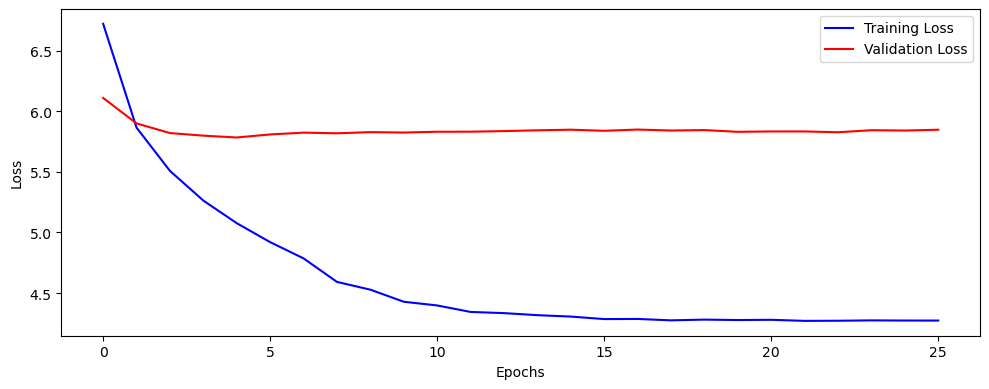

In [8]:
StepByStep.set_seed(96)

model = CBOWModel(vocabulary_size=len(cbow_vocab),
                  embedding_size=50,
                  padding_idx=cbow_vocab[cbow_vocab.pad_tok])


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_loader = DataLoader(CBOWDataset(x_train, y_train), batch_size=32, drop_last=True, shuffle=True)
val_loader = DataLoader(CBOWDataset(x_val, y_val), batch_size=32, drop_last=True, shuffle=True)

sbs = StepByStep(model, loss_fn, optimizer, scheduler)
sbs.set_loaders(train_loader, val_loader)

sbs.train_by_loss_change(1e-3)

sbs.plot_losses(ylog=False)

## Accuracy

In [9]:
(sbs.model(x_test).argmax(dim=1) == y_test).sum() / len(y_test)

tensor(0.1433)

## Trained embeddings

In [10]:
def pretty_print(results):
    for k, v in results:
        print (f"...[{v:.2f}] - {k}")

def get_closest(target_word, vocab, embeddings, n=5):
    """
    Get the n closest
    words to your word.
    """
    # Calculate distances to all other words
    word_embedding = embeddings[vocab[target_word.lower()]]
    distances = []
    for word, index in vocab.items():
        if word == vocab.pad_tok or word == target_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    results = sorted(distances, key=lambda x: x[1])[1:n+2]
    return results


In [11]:
word = "monster"
embeddings = model.embedding.weight.data
pretty_print(get_closest(word, cbow_vocab, embeddings, n=10))

...[4.16] - flying
...[4.20] - dashing
...[4.20] - loathed
...[4.23] - speaker
...[4.26] - eluded
...[4.28] - intertwined
...[4.30] - stump
...[4.31] - world
...[4.33] - perceiving
...[4.35] - sit
...[4.35] - fled


In [12]:
target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely', 'happy']

embeddings = model.embedding.weight.data


for target_word in target_words: 
    print(f"======={target_word}=======")
    if target_word not in cbow_vocab:
        print(f"{target_word} is not in vocabulary")
        continue
    pretty_print(get_closest(target_word, cbow_vocab, embeddings, n=5))

=======frankenstein=======
...[4.27] - drunk
...[4.32] - reception
...[4.37] - perhaps
...[4.39] - stage
...[4.43] - devil
...[4.44] - affected
=======monster=======
...[4.16] - flying
...[4.20] - dashing
...[4.20] - loathed
...[4.23] - speaker
...[4.26] - eluded
...[4.28] - intertwined
=======science=======
...[4.12] - engagement
...[4.15] - misery
...[4.19] - confirmation
...[4.19] - separated
...[4.23] - associate
...[4.24] - division
=======sickness=======
...[4.02] - loudly
...[4.08] - armada
...[4.10] - consist
...[4.14] - helpless
...[4.15] - lived
...[4.25] - dwell
=======lonely=======
...[4.12] - wise
...[4.30] - croaking
...[4.36] - fortunate
...[4.42] - visitor
...[4.45] - order
...[4.49] - frail
=======happy=======
...[3.92] - motive
...[3.96] - inspired
...[4.10] - disturbed
...[4.11] - orders
...[4.13] - all
...[4.14] - icy


In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings2d = pca.fit_transform(embeddings)
embeddings2d

array([[-1.06206582, -0.28316177],
       [ 0.47132198, -0.31631967],
       [ 1.51939754, -0.52102672],
       ...,
       [-0.75143179,  0.38830783],
       [ 0.3093594 , -0.29522186],
       [ 0.07040664, -0.35994224]])

In [19]:
df = pd.DataFrame(embeddings2d, columns=["X", "Y"])
# adding a columns for the corresponding words
df['Words'] = list(cbow_vocab)


import plotly.express as px

# plotting a scatter plot
fig = px.scatter(df, x="X", y="Y", text="Words", log_x=True, size_max=60)
# adjusting the text position
fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(height=600, title_text='Word embeddings')

# displaying the figure
fig.show()